In [ ]:
from keras.layers import Input, Dense, Conv2D, MaxPool2D,UpSampling2D, Add
from skimage.transform import resize, rescale
import matplotlib.pyplot as plt
from keras import regularizers
from scipy import ndimage, misc
from keras.models import Model
import urllib.request
import numpy as np
import keras
import cv2
import os

%matplotlib inline

font_options = {'family' : 'monospace'}
figure_options = {'figsize':[10,6]}
plt.rc('font', **font_options) 
plt.rc('figure', **figure_options)

# Super Resolution: Convolutional Neural Networks, AutoEncoders

Задача улучшения качества изображения является важной, но тем не менее уже решённой задачи в области задач компьютерного зрения. Данная задача относится к категории `Image-to-image` - в качестве входных данных должна подаваться определенная фотография небольшой размерности, а на выходе - та же фотография, но большей размерности (улучшенная).

За время практики я решил ознакомиться с обработкой изображений и их представлением в памяти, поэтому поставил себе некоторые подзадачи, которе необходимы для понимания решения общей задачи:

- научиться обрабатывать изображения и выяснить различные методы `ImagePreprocessing`
- сформировать датасет из изображений для обучения и визуализации результатов
- изучить структуры и процесс обучения `CNN - Convolutional Neural Network` - сверточных нейронных сетей, подходящих для работы с изображениями
- изучить алгоритм `AutoEncoder` и архитектуру сети для задачи `Image-to-Image`
- построить архитектуру сети, обучить модель на предоставленном датасете и отобразить полученные результаты

В качестве решения данной задачи был написан class `super_resolution`, который последовательно проводит следующие преобразования:

- `store_raw_images` - скачивает необходимый сет для обучения данных с помощью введенной ссылки по API. В тестовом варианте использовалось скачивание фотографий из ImageNet
- `get_training_data` - формирует датасет из скачанных фотографий высокого разрешения, ухудшает данные для обучения модели и переводит их в `grayscale` с помощью одноименной функции
- `my_show` и `my_gshow` - визуализация фотографий с помощью библиотеки Matplotlib
- `model` - возвращает модель сверточного автоенкодера, состоящего из енкодера, декодера и Skip-Connection слоёв.
- `fit` - получает на вход параметры, необходимые для обучения нейронной сети и обучает модель последовательно на батчах определенного размера

После этого модель обучалась, с помощью функции `model.predict` получали результаты модели и производилось тестрование результатов на различных фотографиях. Оказалось, что для более универсального обучения модели и недопускания переобучения необходим датасет с большим количеством экземпляров, но мощности моего компьютера не хватило, для того чтобы обучить хотя бы 1000 фотографий.

In [ ]:
def my_show(ax, img, title=None, interpolation='bicubic', **kwargs):
        """
        RGB Visualisation
        """
        ax.imshow(img, interpolation = interpolation, **kwargs)
        ax.axis('off')
        if title:
            ax.set_title(title)

    def my_gshow(ax, img, title=None, cmap='gray', interpolation='bicubic', **kwargs):
        """
        Grayscale visualisation
        """
        my_show(ax, img, title=title, cmap='gray', interpolation=interpolation, **kwargs)

class super_resolution:
     
    def __init__(self,images_location="Images"):
        self.images_location = images_location
        
    def my_show(ax, img, title=None, interpolation='bicubic', **kwargs):
        """
        RGB Visualisation
        """
        ax.imshow(img, interpolation = interpolation, **kwargs)
        ax.axis('off')
        if title:
            ax.set_title(title)

    def my_gshow(ax, img, title=None, cmap='gray', interpolation='bicubic', **kwargs):
        """
        Grayscale visualisation
        """
        my_show(ax, img, title=title, cmap='gray', interpolation=interpolation, **kwargs)
        
    def grayscale(data, dtype='float32'):
        """
        RGB Image To Grayscale
        """
        r, g, b = np.asarray(.3, dtype=dtype), np.asarray(.59, dtype=dtype), np.asarray(.11, dtype=dtype)
        rst = r * data[:, :, :, 0] + g * data[:, :, :, 1] + b * data[:, :, :, 2]
        
        rst = np.expand_dims(rst, axis=3)
        return rst
        
    def store_raw_images(self, max_photo = 1000, images_link = "http://image-net.org/api/text/imagenet.synset.geturls?wnid=n02958343"):
        """
        Donwload Images From ImageNet
        """
        images_urls = urllib.request.urlopen(images_link).read().decode()
        _dir = self.images_location
        amount_of_photo = 0
        if not os.path.exists(_dir ):
            os.makedirs(_dir )

        for i in images_urls.split("\n"):
            try:
                print(i + f"Фото №{amount_of_photo} ")
                urllib.request.urlretrieve(i, f"{_dir }/{str(len(os.listdir(f'{_dir}'))+1)}.jpg")
                amount_of_photo+=1
                if amount_of_photo==max_photo:
                    break
            except Exception as e:
                print(str(e))
            
                
    def get_training_data(self):
        
        """
        
        Output: Rescale Data, Real Images
        
        """
        print(len(os.listdir(self.images_location)))
        real_image_treat_as_y = []
        downsize_image_treat_as_x = []
        i=0
        for img in os.listdir(self.images_location):
            try:
                image = cv2.imread(f"{self.images_location}/{img}", cv2.IMREAD_UNCHANGED)
                reshaped_image = cv2.resize(image, (256, 256))

                if reshaped_image.shape[-1] == 3:
                    real_image_treat_as_y.append(reshaped_image)

                image = cv2.resize(image, (100, 100))

                reshaped_image = cv2.resize(image, (256, 256))

                if reshaped_image.shape[-1] == 3:
                    downsize_image_treat_as_x.append(cv2.resize(image, (256, 256)))
                i +=1
                if i == 1000:
                    break
            except Exception as e:
                
                pass
        return (super_resolution.grayscale(np.array(downsize_image_treat_as_x)), super_resolution.grayscale(np.array(real_image_treat_as_y)))
    
    def model():
        """
        Convolutional AutoEncoder
        """
        
        input= Input(shape=(256, 256, 1)) 

        l1 = Conv2D(64, (3, 3), padding='same', kernel_initializer='he_uniform', \
                    activation='relu', activity_regularizer=regularizers.l1(10e-10),name='Conv_layer1_3x3')(input)
        l2 = Conv2D(64, (3, 3), padding='same', kernel_initializer='he_uniform', \
                    activation='relu', activity_regularizer=regularizers.l1(10e-10),name='Conv_layer2_3x3')(l1)
        l3 = MaxPool2D(padding='same', name='MaxPooling_l3_2x2')(l2)

        l4 = Conv2D(128, (3, 3), padding='same', kernel_initializer='he_uniform', \
                    activation='relu', activity_regularizer=regularizers.l1(10e-10),name='Conv_layer4_3x3')(l3)
        l5 = Conv2D(128, (3, 3), padding='same', kernel_initializer='he_uniform', \
                    activation='relu', activity_regularizer=regularizers.l1(10e-10),name='Conv_layer5_3x3')(l4)
        l6 = MaxPool2D(padding='same', name='MaxPooling_l6_2x2')(l5)

        l7 = Conv2D(256, (3, 3), padding='same', kernel_initializer='he_uniform', \
                    activation='relu', activity_regularizer=regularizers.l1(10e-10),name='Conv_layer7_3x3')(l6)

        l8 = UpSampling2D()(l7)
        l9 = Conv2D(128, (3, 3), padding='same', kernel_initializer='he_uniform', activation='relu', activity_regularizer=regularizers.l1(10e-10))(l8)
        l10 = Conv2D(128, (3, 3), padding='same', kernel_initializer='he_uniform', activation='relu',activity_regularizer=regularizers.l1(10e-10))(l9)

        l11 = Add()([l10, l5])

        l12 = UpSampling2D()(l11)
        l13 = Conv2D(64, (3, 3), padding='same', kernel_initializer='he_uniform', activation='relu', activity_regularizer=regularizers.l1(10e-10))(l12)
        l14 = Conv2D(64, (3, 3), padding='same', kernel_initializer='he_uniform', activation='relu', activity_regularizer=regularizers.l1(10e-10))(l13)

        l15 = Add()([l14, l2])

        decoded_image = Conv2D(1, (3, 3), padding='same', kernel_initializer='he_uniform', activation='relu', activity_regularizer=regularizers.l1(10e-10))(l15)

        auto_encoder = Model(inputs=(input), outputs=decoded_image,name = '')

        auto_encoder.compile(optimizer='adam', loss='mean_absolute_error')
        auto_encoder.summary()
        
        return auto_encoder
    
    def fit(self, just_load_dataset=False,batch_size = 64,num_epochs = 5):
        """
        fitting model
        """
        
        downized_images, real_images = super_resolution.get_training_data(self)
        auto_encoder = super_resolution.model()

        batches = batch_size
        epochs = num_epochs

        batch = 0 
        batch_nb = 0 

        max_batches = -1 

        images = []
        x_train_n = []
        x_train_down = []

        x_train_n2 = []
        x_train_down2 = []
        i = 0

        for low, high in zip(downized_images,real_images):
            if len(low.shape) > 2:
                i +=1
                x_train_n.append(high)
                x_train_down.append(low)
                batch +=1
                if batch == batches:
                    
                    batch_nb += 1

                    x_train_n2 = np.array(x_train_n)
                    x_train_down2 = np.array(x_train_down)

                    if just_load_dataset==False:
                        return x_train_n2, x_train_down2
                    
                    print("New Batch")
                    print('Training batch', batch_nb, '(', batches, ')')

                    auto_encoder.fit(x_train_down2, x_train_n2, epochs= epochs, batch_size=10, shuffle=True, validation_split=0.15)

                    x_train_n = []
                    x_train_down = []

                    batch = 0
        return x_train_n2, x_train_down2

### Создание экземпляра класса

In [ ]:
r=super_resolution(images_location="cats_image")

### Ухудшенное и идеальное изображение

269


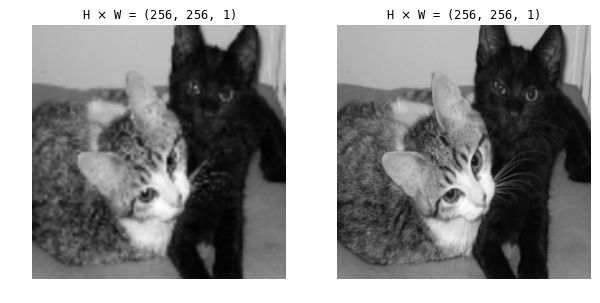

In [43]:
downized_images, real_images = r.get_training_data()

fig, ax = plt.subplots(1,2)

my_gshow(ax[0], downized_images[0].reshape(256,256), title =  fr'H $\times$ W = {downized_images[0].shape}')
my_gshow(ax[1], real_images[0].reshape(256,256), title =  fr'H $\times$ W = {real_images[0].shape}')

### Обучение модели

In [44]:
x_train_n, x_train_down = r.fit(just_load_dataset=True, batch_size=32, num_epochs = 10)

269
Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 256, 256, 1)  0                                            
__________________________________________________________________________________________________
Conv_layer1_3x3 (Conv2D)        (None, 256, 256, 64) 640         input_4[0][0]                    
__________________________________________________________________________________________________
Conv_layer2_3x3 (Conv2D)        (None, 256, 256, 64) 36928       Conv_layer1_3x3[0][0]            
__________________________________________________________________________________________________
MaxPooling_l3_2x2 (MaxPooling2D (None, 128, 128, 64) 0           Conv_layer2_3x3[0][0]            
________________________________________________________________________________________

### Проверка результатов

In [ ]:
sr1 = np.clip(auto_encoder.predict(x_train_down), 0.0, 1.0)

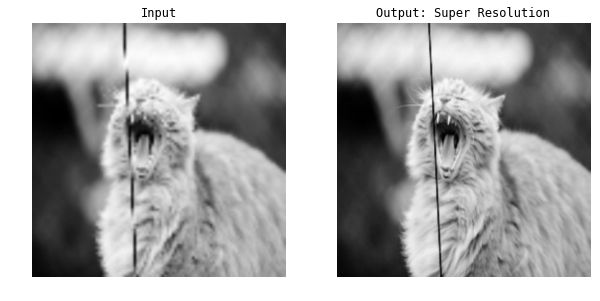

In [67]:
fig, ax = plt.subplots(1,2)

my_gshow(ax[0],x_train_down[image_index].reshape(256,256),title = 'Input')
my_gshow(ax[1],sr1[image_index].reshape(256,256),title='Output: Super Resolution')

In [ ]:
from keras.datasets import cifar10
from keras.utils import np_utils

(X_train, y_train), (X_test, y_test) = cifar10.load_data()

restored = cv2.pyrUp(cv2.pyrUp(cv2.pyrUp(X_train[1])))
fig, ax = plt.subplots(1,1)
my_show(ax, restored)

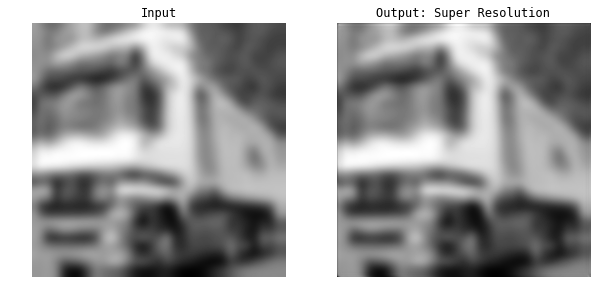

In [113]:
X = restored.reshape(1,256,256,3)
def grayscale(data, dtype='float32'):
        """
        RGB Image To Grayscale
        """
        r, g, b = np.asarray(.3, dtype=dtype), np.asarray(.59, dtype=dtype), np.asarray(.11, dtype=dtype)
        rst = r * data[:, :, :, 0] + g * data[:, :, :, 1] + b * data[:, :, :, 2]
        
        rst = np.expand_dims(rst, axis=3)
        return rst
    
X_gray = grayscale(X)
image = auto_encoder.predict(X_gray).reshape(256,256)
fig, ax = plt.subplots(1,2)

my_gshow(ax[0], X_gray.reshape(256,256) ,title = 'Input')
my_gshow(ax[1], image,title='Output: Super Resolution')

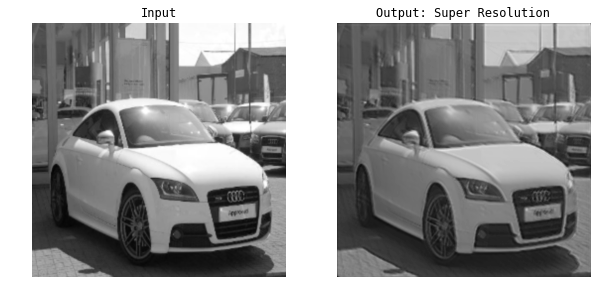

In [114]:
machine = cv2.imread('00001.jpg')
machine = cv2.resize(machine,(256,256))
gray_X = grayscale(machine.reshape(1,256,256,3))
image_2 = auto_encoder.predict(gray_X).reshape(256,256)

fig, ax = plt.subplots(1,2)

my_gshow(ax[0], gray_X.reshape(256,256),title = 'Input')
my_gshow(ax[1], image_2,title='Output: Super Resolution')